In [2]:
# get processed data

import os
import pandas as pd

file_path = "../data/"

data = pd.read_csv(file_path+"train.csv")

In [3]:
# Convert to list

df=data["news_title"]

docs = [str(i) for i in df.values]


In [4]:
import bpemb
from bpemb import BPEmb
import numpy as np

# Load BPEmb model for Tamil

model = BPEmb(lang="ta", dim=300, vs=200000)

# Generate embeddings for news_title column

embeds = []
for title in docs:
    embed = model.embed(title)
    embeds.append(np.mean(embed, axis=0))

embeds = np.array(embeds)

In [5]:
# Tokenize docs trivially (split on spaces)

from indicnlp.tokenize import sentence_tokenize, indic_tokenize

def tokenize_ta(text,return_tensors="pt",*args,**kwargs):
    return indic_tokenize.trivial_tokenize(text)

In [6]:
# Common list of stopwords

stopwords=['அங்கு',
 'அங்கே',
 'அடுத்த',
 'அதனால்',
 'அதன்',
 'அதற்கு',
 'அதிக',
 'அதில்',
 'அது',
 'அதே',
 'அதை',
 'அந்த',
 'அந்தக்',
 'அந்தப்',
 'அன்று',
 'அல்லது',
 'அவன்',
 'அவரது',
 'அவர்',
 'அவர்கள்',
 'அவள்',
 'அவை',
 'ஆகிய',
 'ஆகியோர்',
 'ஆகும்',
 'இங்கு',
 'இங்கே',
 'இடத்தில்',
 'இடம்',
 'இதனால்',
 'இதனை',
 'இதன்',
 'இதற்கு',
 'இதில்',
 'இது',
 'இதை',
 'இந்த',
 'இந்தக்',
 'இந்தத்',
 'இந்தப்',
 'இன்னும்',
 'இப்போது',
 'இரு',
 'இருக்கும்',
 'இருந்த',
 'இருந்தது',
 'இருந்து',
 'இவர்',
 'இவை',
 'உன்',
 'உள்ள',
 'உள்ளது',
 'உள்ளன',
 'எந்த',
 'என',
 'எனக்',
 'எனக்கு',
 'எனப்படும்',
 'எனவும்',
 'எனவே',
 'எனினும்',
 'எனும்',
 'என்',
 'என்ன',
 'என்னும்',
 'என்பது',
 'என்பதை',
 'என்ற',
 'என்று',
 'என்றும்',
 'எல்லாம்',
 'ஏன்',
 'ஒரு',
 'ஒரே',
 'ஓர்',
 'கொண்ட',
 'கொண்டு',
 'கொள்ள',
 'சற்று',
 'சிறு',
 'சில',
 'சேர்ந்த',
 'தனது',
 'தன்',
 'தவிர',
 'தான்',
 'நான்',
 'நாம்',
 'நீ',
 'பற்றி',
 'பற்றிய',
 'பல',
 'பலரும்',
 'பல்வேறு',
 'பின்',
 'பின்னர்',
 'பிற',
 'பிறகு',
 'பெரும்',
 'பேர்',
 'போது',
 'போன்ற',
 'போல',
 'போல்',
 'மட்டுமே',
 'மட்டும்',
 'மற்ற',
 'மற்றும்',
 'மிக',
 'மிகவும்',
 'மீது',
 'முதல்',
 'முறை',
 'மேலும்',
 'மேல்',
 'யார்',
 'வந்த',
 'வந்து',
 'வரும்',
 'வரை',
 'வரையில்',
 'விட',
 'விட்டு',
 'வேண்டும்',
 'வேறு']

from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts for topic representation - TOKENIZATION STEP

vectorizer_model = CountVectorizer(
    stop_words=stopwords,analyzer='word',
    tokenizer=tokenize_ta
)

In [7]:

# Create a BERTopic model

from bertopic import BERTopic
from datetime import datetime

topic_numbers = []
score = []
time=[]

for i in range(15,115,10):

    topic_model = BERTopic(
        vectorizer_model=vectorizer_model,
        verbose=True,
        calculate_probabilities=False,
        embedding_model=model,
        nr_topics=i,
    )

    # Fit the model on the documents

    embeds_np = embeds

    start_time = datetime.now()
    topics = topic_model.fit_transform(docs,embeds_np)
    end_time = datetime.now()
    time_taken = datetime.now() - start_time

    import gensim.corpora as corpora
    from gensim.models.coherencemodel import CoherenceModel

    # Preprocess documents

    cleaned_docs = topic_model._preprocess_text(docs)

    # Extract vectorizer and tokenizer from BERTopic

    vectorizer = topic_model.vectorizer_model
    tokenizer = vectorizer.build_tokenizer()

    # Extract features for Topic Coherence evaluation

    words = vectorizer.get_feature_names_out()
    tokens = [tokenizer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                for topic in range(len(topic_model.get_topics())-1)]


    # Evaluate

    from gensim.models import KeyedVectors
    from gensim.models import word2vec
    from gensim import corpora, models

    # Load pre-trained Word2Vec model for Tamil language

    model_path = "/Users/samyuktha/FYP/data/cc.ta.300.vec.gz"
    w2v_model = KeyedVectors.load_word2vec_format(model_path)

    # Compute coherence score using Word2Vec similarity measure

    cm = CoherenceModel(topics=topic_words, 
                                    texts=tokens, 
                                    corpus=corpus,
                                    dictionary=dictionary, 
    coherence='c_w2v',keyed_vectors=w2v_model)

    coherence_score = cm.get_coherence()

    topic_numbers.append(i)
    score.append(coherence_score)
    time.append(time_taken)



/Users/samyuktha/opt/anaconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2023-04-28 00:29:22,207 - BERTopic - Reduced dimensionality
2023-04-28 00:29:24,141 - BERTopic - Clustered reduced embeddings
2023-04-28 00:29:31,558 - BERTopic - Reduced number of topics from 543 to 15
2023-04-28 00:32:26,648 - BERTopic - Reduced dimensionality
2023-04-28 00:32:28,045 - BERTopic - Clustered reduced embeddings
2023-04-28 00:32:35,970 - BERTopic - Reduced number of topics from 539 to 25
2023-04-28 00:35:38,892 - BERTopic - Reduced dimensionality
2023-04-28 00:35:40,227 - BERTopic - Clustered reduced embeddings
2023-04-28 00:35:48,154 - BERTopic - Reduced number of topics from 528 to 35
2023-04-28 00:38:49,34

In [12]:
scores=pd.DataFrame({"topics":topic_numbers,"score":score,"time": [x.total_seconds() for x in time]})

scores

,topics,score,time
0,15,0.546022,36.728592
1,25,0.548582,21.576446
2,35,0.541714,22.573226
3,45,0.547517,22.484272
4,55,0.549922,24.059651
5,65,0.556533,24.999068
6,75,0.547672,21.750884
7,85,0.551145,21.376632
8,95,0.549138,22.343008
9,105,0.553826,22.929944


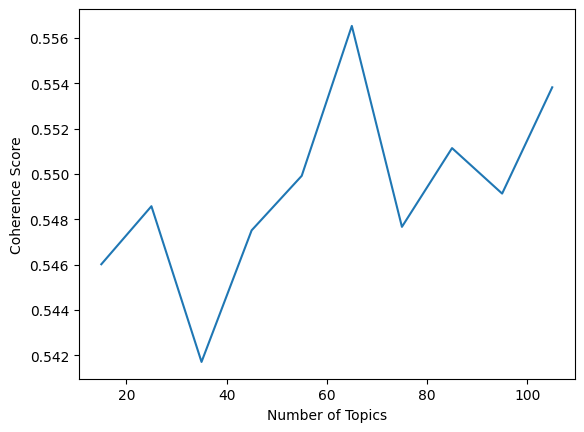

In [14]:
# Plot the coherence score for different number of topics

import matplotlib.pyplot as plt
plt.plot(topic_numbers, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()